In [146]:
import pandas as pd
import numpy as np
import sys
import matplotlib.pyplot as plt
import operator
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import roc_curve, auc
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier


% matplotlib inline

print('Python version', sys.version)
print('Pandas version', pd.__version__)
print('Numpy version', np.__version__)

Python version 3.6.3 |Anaconda custom (64-bit)| (default, Oct  6 2017, 12:04:38) 
[GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
Pandas version 0.20.3
Numpy version 1.14.0


# Import pickled feature data

In [120]:
data = pd.read_pickle('data/feature_engineering.pkl')

In [121]:
data.head()

,id,hour_created,weekday_created,photo_exists,tweet_sentiment,retweets_per_followers,favs_per_followers,rate_all_caps,retweet_count,favorite_count,text_length,target
0,9.529341e+17,16,0,1,1,0.000743,0.002601,0.000000,28,98,203,1
1,9.533119e+17,17,1,1,1,0.000637,0.001805,0.000000,24,68,202,1
2,9.533464e+17,19,1,0,1,0.000212,0.000557,0.060606,8,21,243,1
3,9.536457e+17,15,2,0,1,0.000610,0.003901,0.000000,23,147,61,1
4,9.536777e+17,17,2,0,1,0.000478,0.001327,0.037037,18,50,220,1


# Define Evaluation Functions

In [51]:
# Generate a confusion matrix plot
def plot_confusion_matrix(cm, title='Confusion Matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [52]:
def find_auc(y_test, y_score):
    
    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()

    plt.plot([0,1],[0,1]) # this is our baseline
    plt.plot(fpr, tpr) # this is our ROC curve
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.show()

    print('AUC: ', roc_auc)

In [67]:
def split_train_test(features, target, test_size, seed):
    """
    Split data into training and test sets before cross validation on training set
    """
    assert isinstance(features, np.ndarray) and isinstance(target, np.ndarray), 'Inputs and target must be np.arrays'

    # Split features and response into training and validation sets
    validation_size = test_size
    X_train, X_validation, Y_train, Y_validation = train_test_split(features, target,
                                                                    test_size=validation_size,
                                                                    random_state=seed)

    return X_train, X_validation, Y_train, Y_validation

In [177]:
def find_best_classifier(features, target, seed, k_folds, crossval_scoring, feature_names):

    """
    Test multiple classifiers using cross validation.
    Evaluate performance to find model with highest score as defined by the 'crossval_scoring' argument 
    ('roc_auc', 'f1', log_loss', precision', 'recall', etc)
    """

    # Test options and evaluation metric
    scoring=crossval_scoring

    # Spot Check Algorithms
    models = []
    models.append(('LogisticRegression', LogisticRegression()))
    models.append(('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis()))
    models.append(('KNeighborsClassifier', KNeighborsClassifier()))
    models.append(('DecisionTree', DecisionTreeClassifier(random_state=seed)))
    models.append(('NaiveBayesGaussian', GaussianNB()))
    models.append(('RandomForest', RandomForestClassifier(random_state=seed)))
    models.append(('GradientBoosting', GradientBoostingClassifier(random_state=seed)))


    # Evaluate each model in turn
    results = []
    names = []

    for name, model in models:
        kfold = StratifiedKFold(n_splits=k_folds, random_state=seed)
        cv_results = cross_val_score(model, features, target, cv=kfold, scoring=scoring)
        results.append(cv_results)
        names.append(name)
        msg = "%s: %s (%f), std (%f)" % (name, scoring, cv_results.mean(), cv_results.std())
        print(msg)

    zipped_eval = zip(models, [i.mean() for i in results])
    model_eval = sorted(zipped_eval, key=operator.itemgetter(1))
    
    best_clf = model_eval[-1][0][1]
    clf_name = model_eval[-1][0][0]
    print("\n Model with best {} is {}".format(scoring, clf_name))
    print('\n', best_clf)
    
    print('\n Feature Importance:')
    try:
        clf = best_clf
        clf.fit(features, target)

        for i in zip(feature_names, clf.feature_importances_):
            print(i)
            
        feat_imp = pd.Series(clf.feature_importances_, feature_names).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        
    except AttributeError:
        print(' Not available for {}'.format(clf_name))
        
    return best_clf

# Find Best Classifier

In [122]:
target_array = np.array(data.pop('target'))

features = data.drop(['id'], axis=1)
features_array = np.array(features)

In [123]:
X_train, X_validation, Y_train, Y_validation = split_train_test(features=features_array, target=target_array, 
                                                                test_size=.2, seed=42)

## Test for optimal ROC AUC Score

LogisticRegression: roc_auc (0.601250), std (0.006657)
LinearDiscriminantAnalysis: roc_auc (0.612965), std (0.008093)
KNeighborsClassifier: roc_auc (0.587161), std (0.005404)
DecisionTree: roc_auc (0.601618), std (0.011406)
NaiveBayesGaussian: roc_auc (0.607076), std (0.005923)
RandomForest: roc_auc (0.702207), std (0.002739)
GradientBoosting: roc_auc (0.715540), std (0.005188)

 Model with best roc_auc is GradientBoosting

 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

 Feature Importance:
('hour_created', 0.0792104946823181)
('weekday_created', 0.05179180473767546)
('

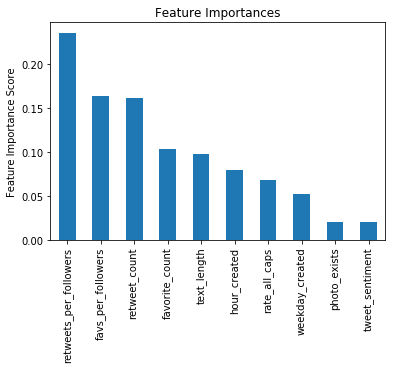

In [178]:
best_clf = find_best_classifier(features=X_train, 
                                target=Y_train, 
                                seed=42, 
                                k_folds=5, 
                                crossval_scoring='roc_auc', 
                                feature_names=list(features))

## Test for optimal Log Loss

LogisticRegression: neg_log_loss (-0.672734), std (0.001649)
LinearDiscriminantAnalysis: neg_log_loss (-0.670035), std (0.001855)
KNeighborsClassifier: neg_log_loss (-2.101345), std (0.073938)
DecisionTree: neg_log_loss (-13.634311), std (0.399215)
NaiveBayesGaussian: neg_log_loss (-0.925532), std (0.096007)
RandomForest: neg_log_loss (-0.846377), std (0.021952)
GradientBoosting: neg_log_loss (-0.613967), std (0.003324)

 Model with best neg_log_loss is GradientBoosting

 GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

 Feature Importance:
('hour_created', 0.0792104946823

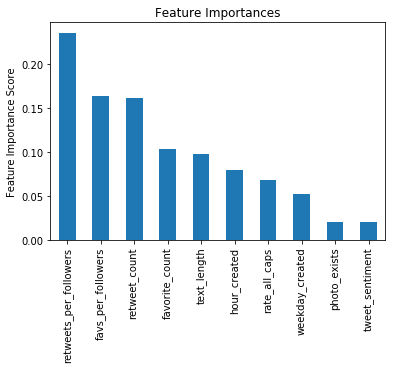

In [179]:
best_clf = find_best_classifier(features=X_train, 
                                target=Y_train, 
                                seed=42, 
                                k_folds=5, 
                                crossval_scoring='neg_log_loss', 
                                feature_names=list(features))

## Test for optimal F1 Score

In [180]:
best_clf = find_best_classifier(features=X_train, 
                                target=Y_train, 
                                seed=42, 
                                k_folds=5, 
                                crossval_scoring='f1', 
                                feature_names=list(features))

LogisticRegression: f1 (0.443890), std (0.016677)
LinearDiscriminantAnalysis: f1 (0.441822), std (0.007588)
KNeighborsClassifier: f1 (0.513252), std (0.007778)
DecisionTree: f1 (0.563511), std (0.011986)
NaiveBayesGaussian: f1 (0.619819), std (0.001343)
RandomForest: f1 (0.564793), std (0.003070)
GradientBoosting: f1 (0.597921), std (0.010467)

 Model with best f1 is NaiveBayesGaussian

 GaussianNB(priors=None)

 Feature Importance:
 Not available for NaiveBayesGaussian


# Find Best Parameters

In [204]:
def find_best_params(model, parameter_dict, scoring, features, target, feature_names):
    """
    Use GridSearchCV to find optimal parameters for a given model
    """
    gsearch = GridSearchCV(estimator=model, param_grid=parameter_dict, 
                           scoring=scoring,n_jobs=4,iid=False, cv=5)
    
    gsearch.fit(features, target)
    
    print(gsearch.best_score_)
    print(gsearch.best_params_)


## Find best number estimators

In [224]:
gbc1 =  GradientBoostingClassifier(criterion='friedman_mse', 
                                  init=None,
                                  learning_rate=0.1, 
                                  loss='deviance', 
                                  max_depth=3,
                                  max_features=None, 
                                  max_leaf_nodes=None,
                                  min_impurity_decrease=0.0, 
                                  min_impurity_split=None,
                                  min_samples_leaf=1, 
                                  min_samples_split=2,
                                  min_weight_fraction_leaf=0.0,
                                  presort='auto', 
                                  random_state=42, 
                                  subsample=1.0, 
                                  verbose=0,
                                  warm_start=False)

In [225]:
parameters1 = {'n_estimators':range(20,200,10)}

In [226]:
find_best_params(model=gbc1, 
                 parameter_dict=parameters1, 
                 scoring='neg_log_loss',
                 features=X_train,
                 target=Y_train,
                 feature_names=list(X))

-0.6041213345741652
{'n_estimators': 190}


## Find best learning rate

In [227]:
gbc2 =  GradientBoostingClassifier(criterion='friedman_mse', 
                                  init=None, 
                                  loss='deviance', 
                                  max_depth=3,
                                  max_features=None, 
                                  max_leaf_nodes=None,
                                  min_impurity_decrease=0.0, 
                                  min_impurity_split=None,
                                  min_samples_leaf=1, 
                                  min_samples_split=2,
                                  min_weight_fraction_leaf=0.0,
                                  presort='auto',
                                  n_estimators=190,
                                  random_state=42, 
                                  subsample=1.0, 
                                  verbose=0,
                                  warm_start=False)

In [242]:
parameters2 = {'learning_rate':[0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.5, 1.0, 10.0]}

In [243]:
find_best_params(model=gbc2, 
                 parameter_dict=parameters2, 
                 scoring='neg_log_loss',
                 features=X_train,
                 target=Y_train,
                 feature_names=list(X))

-0.5697488650469011
{'learning_rate': 0.5}


## Find best max_depth and min_samples_leaf

In [255]:
gbc3 =  GradientBoostingClassifier(criterion='friedman_mse', 
                                  init=None, 
                                  loss='deviance', 
                                  max_features=None, 
                                  max_leaf_nodes=None,
                                  min_impurity_decrease=0.0, 
                                  min_impurity_split=None,
                                  min_samples_split=2,
                                  min_weight_fraction_leaf=0.0,
                                  presort='auto',
                                  n_estimators=190,
                                  random_state=42,
                                  learning_rate=0.5, 
                                  subsample=1.0, 
                                  verbose=0,
                                  warm_start=False)

In [256]:
parameters3 = {'max_depth':[3, 5, 8, 10],
               'min_samples_leaf':range(1, 100, 10)}

In [257]:
find_best_params(model=gbc3, 
                 parameter_dict=parameters3, 
                 scoring='neg_log_loss',
                 features=X_train,
                 target=Y_train,
                 feature_names=list(X))

-0.5560744626573444
{'max_depth': 5, 'min_samples_leaf': 11}


## Visualize Results of Best Classifier on Test Set

In [258]:
def train_test_score(best_classifier, X_train, X_validation, Y_train, Y_validation):
    
    # fit a model
    clf = best_classifier.fit(X_train, Y_train)
    
    # score the model (accuracy)
    train_acc = clf.score(X_train, Y_train)
    test_acc = clf.score(X_validation, Y_validation)
    print("Training Data Accuracy: %0.2f" %(train_acc))
    print("Test Data Accuracy:     %0.2f" %(test_acc))

    # create a confusion matrix
    y_true = Y_validation
    y_pred = clf.predict(X_validation)
    
    conf = confusion_matrix(y_true, y_pred)
    print ('\n')
    print(conf)

    print ('\n')
    print ("Precision:              %0.2f" %(conf[1, 1] / (conf[0, 1] + conf[1, 1])))
    print ("Recall:                 %0.2f"% (conf[1, 1] / (conf[1, 0] + conf[1, 1])))

    cm = confusion_matrix(y_true, y_pred, labels=None)
    # plot the confusion matrix

    print ('\n')
    plt.figure()
    plot_confusion_matrix(cm)
    plt.show()
       
    print('\n')
    find_auc(y_test=y_true, y_score=y_pred)

In [261]:
tuned_classifier = GradientBoostingClassifier(criterion='friedman_mse', 
                                             init=None, 
                                             loss='deviance', 
                                             max_depth=5,
                                             max_features=None, 
                                             max_leaf_nodes=None,
                                             min_impurity_decrease=0.0, 
                                             min_impurity_split=None,
                                             min_samples_leaf=11, 
                                             min_samples_split=2,
                                             min_weight_fraction_leaf=0.0,
                                             presort='auto',
                                             n_estimators=190,
                                             random_state=42, 
                                             subsample=1.0, 
                                             verbose=0,
                                             learning_rate=0.5,
                                             warm_start=False)

Training Data Accuracy: 0.89
Test Data Accuracy:     0.74


[[3053  816]
 [ 981 2157]]


Precision:              0.73
Recall:                 0.69




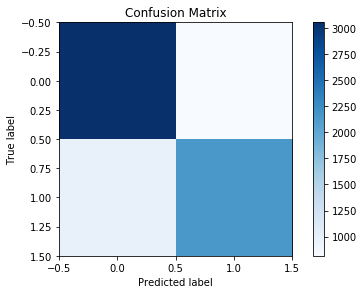

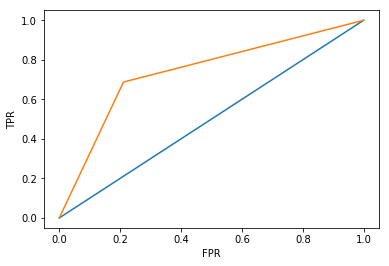

AUC:  0.7382366429831276


In [260]:
train_test_score(tuned_classifier, X_train, X_validation, Y_train, Y_validation)

# Fit All and Pickle Best CLF

In [262]:
tuned_classifier.fit(features_array, target_array)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.5, loss='deviance', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=11, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=190,
              presort='auto', random_state=42, subsample=1.0, verbose=0,
              warm_start=False)

In [265]:
with open('models/gcb_clf_base_features.pkl', 'wb') as file:
    pickle.dump(tuned_classifier, file)